# Deep Image Neural Net w/ CIFAR10

I only trained each model to 10 epochs because I have limited hardware and time, but that's usually enough to tell when one model is clearly beating another.

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.CIFAR10(
    root="datasets", train=True, download=True, transform=toTensor
)
test_data = torchvision.datasets.CIFAR10(
    root="datasets", train=False, download=True, transform=toTensor
)

train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [45000, 5000]
)
device = "cuda"

In [9]:
def eval(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [2]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,10)
)
for idx, module in model.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

device = "cuda"

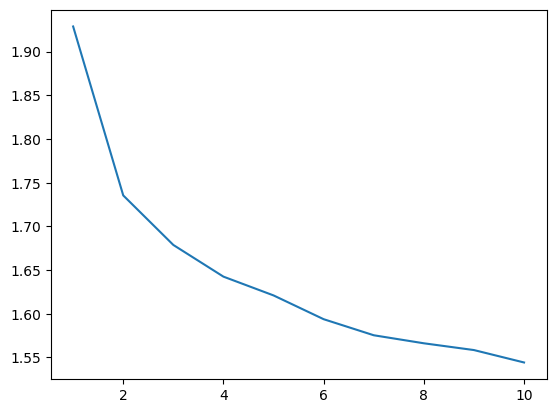

In [3]:
def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    loss_epochs = []
    for epoch in range(1, n_epochs+1):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            total_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()
        loss_epochs.append((epoch, total_loss/len(train_loader)))
    return loss_epochs

model.to(device)
lr = .003
optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
losses = train(model, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [13]:
# Evaluation of Model 1 
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
loss, accuracy = eval(model, xentropy, valid_loader)
print("Model 1 Loss:", loss)
print("Model 1 Accuracy:", accuracy)

Model 1 Loss: 1.6331544636161464
Model 1 Accuracy: 0.4148


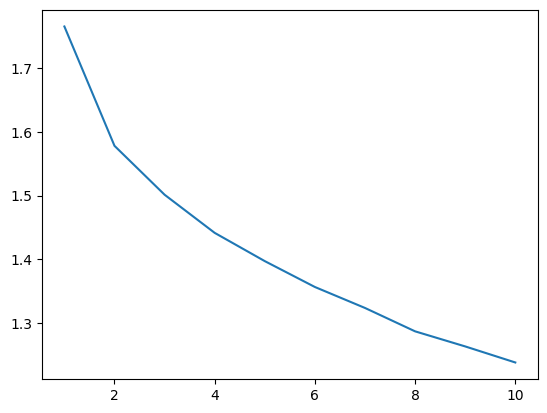

In [4]:
# Same model, but with batch norm

model2 = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(3*32*32), nn.Linear(3*32*32, 100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.BatchNorm1d(100), nn.Linear(100,100), nn.SiLU(),
    nn.Linear(100,10)
)
for idx, module in model2.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model2.to(device)
lr = .003
optimizer = torch.optim.NAdam(model2.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
losses = train(model2, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [14]:
# Evaluation of Model 2
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
loss, accuracy = eval(model2, xentropy, valid_loader)
print("Model 2 Loss:", loss)
print("Model 2 Accuracy:", accuracy)

Model 2 Loss: 1.3268079886770552
Model 2 Accuracy: 0.526


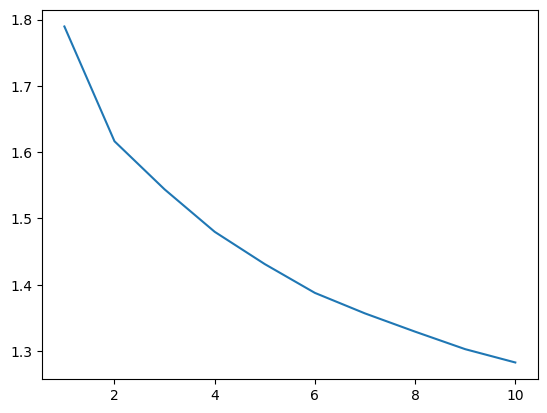

In [36]:
# Replacing Batch Norm+Swish w/ SeLU + LeCun initialization
import numpy as np

model3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,100), nn.SELU(),
    nn.Linear(100,10)
)
for idx, module in model3.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=1.0/np.sqrt(module.weight.size(1)))
        nn.init.zeros_(module.bias)

all_imgs = torch.stack([img for img, _ in train_data])
mean = all_imgs.mean()
std = all_imgs.std()
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in train_data])
train_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

model3.to(device)
lr = .003
optimizer = torch.optim.NAdam(model3.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data_normalized, batch_size=32, shuffle=True)
losses = train(model3, optimizer, xentropy, train_loader, 10)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [42]:
# Evaluation of Model 3
all_imgs = torch.stack([img for img, _ in valid_data])
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in valid_data])
valid_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = eval(model3, xentropy, valid_loader)
print("Model 3 Loss:", loss)
print("Model 3 Accuracy:", accuracy)

Model 3 Loss: 1.5335862682123853
Model 3 Accuracy: 0.4812


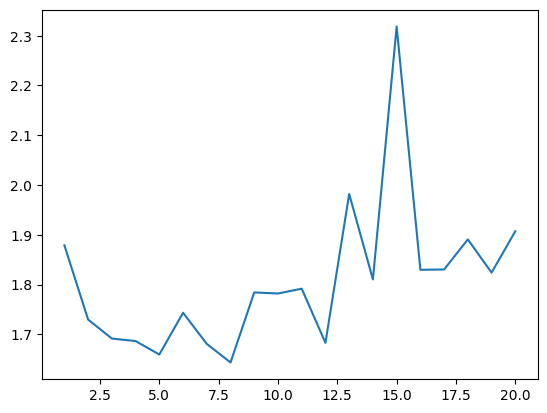

In [44]:
# Adding Alpha Dropout to Model 3

model3a = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,100), nn.SELU(), nn.AlphaDropout(.1),
    nn.Linear(100,10)
)
for idx, module in model3a.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, std=1.0/np.sqrt(module.weight.size(1)))
        nn.init.zeros_(module.bias)

model3a.to(device)
lr = .003
optimizer = torch.optim.NAdam(model3a.parameters(), lr=lr)
xentropy = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_data_normalized, batch_size=32, shuffle=True)
losses = train(model3a, optimizer, xentropy, train_loader, 20)
plt.plot([x[0] for x in losses], [x[1] for x in losses])
plt.show()

In [52]:
all_imgs = torch.stack([img for img, _ in valid_data])
imgs_normalized = (all_imgs - mean) / std
labels = torch.tensor([lab for img, lab in valid_data])
valid_data_normalized = torch.utils.data.TensorDataset(imgs_normalized, labels)

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = eval(model3a, xentropy, valid_loader)
print("Model 3a Loss:", loss)
print("Model 3a Accuracy:", accuracy)

Model 3a Loss: 1.8743323011762778
Model 3a Accuracy: 0.3714


In [51]:
# Adding MC Dropout to Improve 3a

def evalMC(model, criterion, test_loader):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = []
            for i in range(100):
                y_pred.append(model(X_batch))
            y_pred = torch.stack(y_pred).mean(dim=0)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

valid_loader = torch.utils.data.DataLoader(valid_data_normalized, batch_size=32, shuffle=True)
loss, accuracy = evalMC(model3a, xentropy, valid_loader)
print("Model 3a Loss:", loss)
print("Model 3a Accuracy:", accuracy)

Model 3a Loss: 1.8233766122988075
Model 3a Accuracy: 0.3664
